# Multivariate, Multistep LSTM Implementation

An implementation of a multivariate, multistep LSTM for the Close price of NYSE: ECL operating on daily resolution. The model uses 30 timesteps back to predict 30 timesteps forward. Data pre-processing has been completed in a separate notebook.

## Table of Contents
* Libraries
* Load Data
  * Split Data
* Vanilla LSTM
* LSTM Optimization
* LSTM Walk Forward Validation
* Validation Results
  * Overall
  * First Model
  * Last Model
* Conclusions

## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import tqdm
%matplotlib inline

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3337606751571228959
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13553856756599032950
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10907433009490338403
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15848577434
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4258445338638579588
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


## Load the data
#### Daily Resolution Data

In [3]:
if True:
    keep_col = list(range(1,18))

    df_day = pd.read_csv('ECL_Clean_Day.csv', 
                         infer_datetime_format=True,
                         parse_dates=['Timestamp'], 
                         index_col=['Timestamp'],
                         usecols = keep_col,
                         date_parser=lambda col: pd.to_datetime(col, utc=True).tz_convert('America/New_York'))

    #df_day.dtypes
    print ('Shape of df_day:',df_day.shape,'\n')

df_day.head(3)

Shape of df_day: (5031, 16) 



,Open,High,Low,Close,Volume,SMA_10,SMA_50,EMA_10,EMA_50,RSI,ROC,MACD_Line,MACD_Diff,MACD_Sig,WO,ATR
Timestamp,,,,,,,,,,,,,,,,
2000-01-03 00:00:00-05:00,19.500,19.500,18.750,18.813,580000,NaN,NaN,NaN,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,0.0
2000-01-04 00:00:00-05:00,18.813,18.969,9.000,9.188,1528798,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.0
2000-01-05 00:00:00-05:00,9.250,19.188,9.188,19.063,700200,NaN,NaN,NaN,NaN,52.491694,NaN,NaN,NaN,NaN,NaN,0.0


#### Split the data

We'll use the past 10 years of data

In [4]:
# create 10 years of data from 2019 - 2010
day_data = df_day[df_day.index >= '2010-01-01']

#split 7 years train, 3 years test
day_train = day_data[day_data.index <= '2017-01-01']
day_test = day_data[day_data.index >= '2017-01-01']

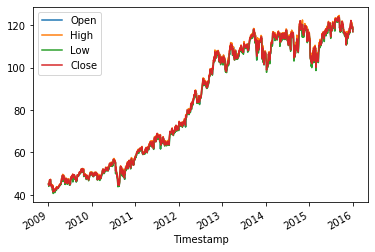

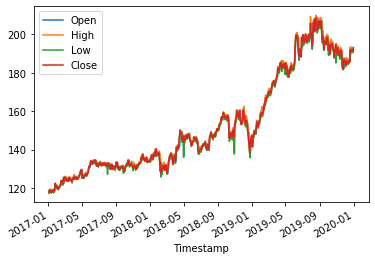

In [5]:
ax1 = day_train.plot(y = ['Open', 'High', 'Low', 'Close'])
ax2 = day_test.plot(y = ['Open', 'High', 'Low', 'Close'])
plt.show()

In [6]:
day_test['Close'][30:100].values.shape

(70,)

## Vanilla LSTM

Prepare the data as a supervised learning problem, scale it then initialize a vanilla LSTM.

In [7]:
#Move Close to last column

day_data = day_data[['Open', 'High', 'Low', 'Volume', 'SMA_10', 'SMA_50', 'EMA_10', 'EMA_50', 'RSI', 'ROC', 
                     'MACD_Line', 'MACD_Diff', 'MACD_Sig', 'WO', 'ATR', 'Close']]
day_data.head(1)

,Open,High,Low,Volume,SMA_10,SMA_50,EMA_10,EMA_50,RSI,ROC,MACD_Line,MACD_Diff,MACD_Sig,WO,ATR,Close
Timestamp,,,,,,,,,,,,,,,,
2010-01-04 00:00:00-05:00,45.08,45.3392,44.86,916222,44.999,45.22915,45.055742,45.076137,51.221295,0.578163,-0.020395,0.003299,-0.023694,53.668896,0.631162,45.23


In [8]:
#from: machinelearningmastery.com/blog/

def time_series_to_supervised(data, n_lag=1, n_fut=1, selLag=None, selFut=None, dropnan=True):
    """
    Converts a time series to a supervised learning data set by adding time-shifted prior and future period
    data as input or output (i.e., target result) columns for each period
    :param data:  a series of periodic attributes as a list or NumPy array
    :param n_lag: number of PRIOR periods to lag as input (X); generates: Xa(t-1), Xa(t-2); min= 0 --> nothing lagged
    :param n_fut: number of FUTURE periods to add as target output (y); generates Yout(t+1); min= 0 --> no future periods
    :param selLag:  only copy these specific PRIOR period attributes; default= None; EX: ['Xa', 'Xb' ]
    :param selFut:  only copy these specific FUTURE period attributes; default= None; EX: ['rslt', 'xx']
    :param dropnan: True= drop rows with NaN values; default= True
    :return: a Pandas DataFrame of time series data organized for supervised learning
    NOTES:
    (1) The current period's data is always included in the output.
    (2) A suffix is added to the original column names to indicate a relative time reference: e.g., (t) is the current
        period; (t-2) is from two periods in the past; (t+1) is from the next period
    (3) This is an extension of Jason Brownlee's series_to_supervised() function, customized for MFI use
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    origNames = df.columns
    cols, names = list(), list()
    # include all current period attributes
    cols.append(df.shift(0))
    names += [('%s' % origNames[j]) for j in range(n_vars)]
 
    # lag any past period attributes (t-n_lag,...,t-1)
    n_lag = max(0, n_lag)  # force valid number of lag periods
    for i in range(n_lag, 0, -1):
        suffix= '(t-%d)' % i
        if (None == selLag):   # copy all attributes from PRIOR periods?
            cols.append(df.shift(i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:
            for var in (selLag):
                cols.append(df[var].shift(i))
                names+= [('%s%s' % (var, suffix))]
 
    # include future period attributes (t+1,...,t+n_fut)
    n_fut = max(n_fut, 0)  # force valid number of future periods to shift back
    for i in range(1, n_fut + 1):
        suffix= '(t+%d)' % i
        if (None == selFut):  # copy all attributes from future periods?
            cols.append(df.shift(-i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:  # copy only selected future attributes
            for var in (selFut):
                cols.append(df[var].shift(-i))
                names += [('%s%s' % (var, suffix))]
    # combine everything
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values introduced by lagging
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
# Convert data to supervised learning problem

data = time_series_to_supervised(day_data, n_lag=30, n_fut=30, selFut=['Close'])
print ('Shape of data:', data.shape)

Shape of data: (2456, 526)


In [10]:
# Peek at the dataframe columns

if False:
    for i in data.columns:
        print (i)

In [11]:
#breaking down the problem to split the data

n_features_in = day_data.shape[1]
n_features_out = 1
n_lags_in = 30
n_lags_out = 30

n_obs_in = (n_features_in * n_lags_in)
n_obs_out = (n_features_out * n_lags_out)
print ('Number of observations in:',n_obs_in)
print ('Number of predictions out:', n_obs_out)

# Creating X, y from data_test
X = data.values[:, :n_obs_in]
y = data.values[:, -n_obs_out:]
print ('\nShape of X:',X.shape)
print ('Shape of y:', y.shape)

Number of observations in: 480
Number of predictions out: 30

Shape of X: (2456, 480)
Shape of y: (2456, 30)


In [12]:
#Initializing a separate scaler for X and y

from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler(feature_range=(0,1)).fit(X)
y_scaler = MinMaxScaler(feature_range=(0,1)).fit(y)

In [13]:
#Split X, y into X_train/X_test and y_train/y_test

n_train = 1732 # splits as above

# split X, y into train/test
X_train, y_train = X[:n_train, :], y[:n_train, :]
X_test, y_test = X[n_train:, :], y[n_train:, :]
print('Shape of splits:')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Shape of splits:
(1732, 480) (1732, 30) (724, 480) (724, 30)


In [14]:
# Using the X,y scalers, scale the data

X_train, y_train = X_scaler.transform(X_train), y_scaler.transform(y_train)
X_test, y_test = X_scaler.transform(X_test), y_scaler.transform(y_test)

In [15]:
# reshape input to be 3D [samples, timesteps, features] for LSTM

n_features = day_data.shape[1]
n_lag = 30

X_train = X_train.reshape((X_train.shape[0], n_lag, n_features))
X_test = X_test.reshape((X_test.shape[0], n_lag, n_features))
print('Re-shaped for LSTM:')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Re-shaped for LSTM:
(1732, 30, 16) (1732, 30) (724, 30, 16) (724, 30)


In [16]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=((X_train.shape[1]), X_train.shape[2])))
model.add(Dense(n_lags_out))
model.compile(optimizer='adam', loss='mae')
model.summary()

history = model.fit(X_train, y_train, 
                    epochs=20,
                    validation_data=(X_test, y_test), 
                    verbose=1, shuffle=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                13400     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
Total params: 14,930
Trainable params: 14,930
Non-trainable params: 0
_________________________________________________________________

Train on 1732 samples, validate on 724 samples
Epoch 1/20
1732/1732 [==============================] - 2s 1ms/step - loss: 0.0657 - val_loss: 0.2627
Epoch 2/20
1732/1732 [==============================] - 1s 819us/step - loss: 0.0770 - val_loss: 0.1181
Epoch 3/20
1732/1732 [==============================] - 1s 802us/step - loss: 0.0710 - val_loss: 0.1234
Epoch 4/20
1732/1732 [==============================] - 1s 798us/step - loss: 0.0431 - val_loss: 0.0998
Epoch 5/20
1732/1732 [============================

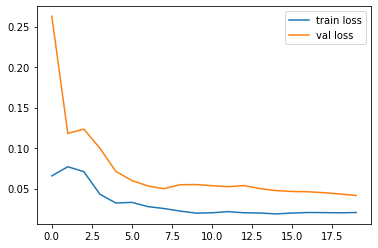

In [17]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

### LSTM Training Results
* Model appears to train without overfit
* This is obviously a very simple model and no further optimization will be done on it.

### Demonstrate Prediction

In [18]:
# Use X_test[0] as test
x_input = X_test[0]
print ('Shape of X_test[0]:,',X_test[0].shape)

# Reshape X_test[0]
x_input = x_input.reshape((1, n_lags_in, n_features))
print ('Shape of x_input:', x_input.shape)

# Make a prediction
yhat = model.predict(x_input, verbose=0)
print ('Shape of yhat:', yhat.shape)

Shape of X_test[0]:, (30, 16)
Shape of x_input: (1, 30, 16)
Shape of yhat: (1, 30)


In [19]:
#Invert the scaling of yhat

inv_yhat = y_scaler.inverse_transform(yhat)

In [20]:
#Reshape and invert scaling for y_test[0]

print ('Shape of y_test[0] before:',y_test[0].shape)
#Reshape y_test[0] to same shape as y_scaler
y_test = y_test[0].reshape(1, y_test[0].shape[0])
print ('Shape of y_test[0] after:', y_test.shape)

#invert scaling for y_test
inv_y = y_scaler.inverse_transform(y_test)

Shape of y_test[0] before: (30,)
Shape of y_test[0] after: (1, 30)


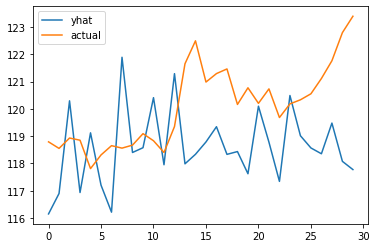

In [21]:
#plot inv_yhat and inv_y

plt.plot(inv_yhat[0], label='yhat')
plt.plot(inv_y[0], label='actual')
plt.legend()
plt.show()

In [22]:
mae = metrics.mean_absolute_error(inv_y[0], inv_yhat[0])
rmse = metrics.mean_squared_error(inv_y[0], inv_yhat[0])
print ('Mean Absolute Error:', mae)
print ('Mean Squared Error:', rmse)

Mean Absolute Error: 2.1277331746419272
Mean Squared Error: 6.185082424138508


* Results suggest even this very simple LSTM has the potential to outperform the baseline model. This is only a single prediction step so I can't read into this very far.


## LSTM Architecture Optimization
* In order to arrive at an optimized architecture for the LSTM, I have used the ```talos``` library. This allows an extensive grid search to be setup and then automated. This has been conduced on a Google Cloud VM. The Jupyter Notebook used can be found accompanying the project submission.<br>
* The best architecture from this grid search is summarized below.

In [23]:
#Define the LSTM Model from the Talos grid search in a function to be called in the loop below

def LSTM_model():
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_lags_in, n_features)))
    model.add(LSTM(100, activation='relu', return_sequences=True))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(400))
    model.add(Dense(400))
    model.add(Dense(400))
    model.add(Dense(n_lags_out))
    model.compile(optimizer='Adam', loss='mse')
    return model

#### Optimized Architecture

In [24]:
model = LSTM_model()
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 100)           46800     
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 400)               40400     
_________________________________________________________________
dense_3 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_5 (Dense)              (None, 30)               

## Walk-Forward Validation w/ re-fit

Validate the model by waking it forward on the training set. Testing set size is kept stationary. Step size is 30 which is intended to mimic a realistic situation of re-training once per month.

In [25]:
# create the dataset for validation

dataset = time_series_to_supervised(day_data, n_lag=30, n_fut=30, selFut=['Close'])

n_features_in = day_data.shape[1]
n_features_out = 1
n_lags_in = 30
n_lags_out = 30

n_obs_in = (n_features_in * n_lags_in)
n_obs_out = (n_features_out * n_lags_out)
print ('Number of observations in:',n_obs_in)
print ('Number of predictions out:', n_obs_out)

# Creating X, y from data_test
X = dataset.values[:, :n_obs_in]
y = dataset.values[:, -n_obs_out:]
print ('\nShape of X:',X.shape)
print ('Shape of y:', y.shape)

Number of observations in: 480
Number of predictions out: 30

Shape of X: (2456, 480)
Shape of y: (2456, 30)


In [26]:
#create and fit the scalers the input data

X_scaler = MinMaxScaler(feature_range=(0,1)).fit(X)
y_scaler = MinMaxScaler(feature_range=(0,1)).fit(y)

In [27]:
#Inputs for Walk-Forward with re-fit at each step
n_train = 1732
n_records = len(dataset)
step = 30
n_lags_in = 30
n_lags_out = 30
n_features = day_data.shape[1]

pred_dict = dict()
errors = list()
count = 0

#Main Loop
for i in tqdm.tqdm_notebook(np.arange(n_train, n_records, step)):
    
    #split the data
    X_train, y_train = X[:i , :], y[:i, :]
    X_test, y_test = X[n_train:, :], y[n_train:, :]
    
    #scale the data
    X_train, y_train = X_scaler.transform(X_train), y_scaler.transform(y_train)
    X_test, y_test = X_scaler.transform(X_test), y_scaler.transform(y_test)
    
    #reshape to 3D for LSTM
    X_train = X_train.reshape((X_train.shape[0], n_lags_in, n_features))
    X_test = X_test.reshape((X_test.shape[0], n_lags_in, n_features))
    
    #create model
    model = LSTM_model()
    es = EarlyStopping(monitor='val_loss', 
                       mode='auto',
                       patience=50,
                       restore_best_weights=True)
    
    #fit the model
    model_fit = model.fit(X_train, 
                          y_train, 
                          validation_data=(X_test, y_test), 
                          callbacks=[es],
                          epochs=100, 
                          batch_size = 120,
                          verbose=1, shuffle=False)
    
    #create the prediction counter for X_test loop
    test_count = 0
    
    #reset list for all the predictions
    predictions = list()
    
    #reset dict to catch all the output dfs (res)
    fore_dict = dict()
    
    #predict loop for each sample in X_test
    for t in np.arange(0, len(X_test), 1):
        x_input = X_test[t]
        x_input = x_input.reshape((1, n_lags_in, n_features))
        yhat = model.predict(x_input, verbose=0)
        inv_yhat = y_scaler.inverse_transform(yhat)
        predictions.append(inv_yhat[0])
        
        #create output df and save into dict
        res = pd.DataFrame(list(range(1,n_lags_out+1)), columns=['Day'])
        res['Pred'] = inv_yhat[0]
        fore_dict[test_count] = res
        test_count += 1
    
    pred_dict[count] = fore_dict
    
    #calculate error for all predictions (X_test)
    inv_y_test = y_scaler.inverse_transform(y_test)
    mae = metrics.mean_absolute_error(inv_y_test, predictions)
    rmse = metrics.mean_squared_error(inv_y_test, predictions)
    err = [count+1, mae, rmse]
    errors.append(err)
    
    #print update
    print('Step:',count+1)
    print('MAE:',mae)
    print('RMSE:',rmse)
    print('\n')
    
    #increase counter
    count += 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Train on 1732 samples, validate on 724 samples
Epoch 1/100
1732/1732 [==============================] - 2s 1ms/step - loss: 0.0020 - val_loss: 0.0239
Epoch 2/100
1732/1732 [==============================] - 1s 614us/step - loss: 0.0720 - val_loss: 0.0629
Epoch 3/100
1732/1732 [==============================] - 1s 611us/step - loss: 0.0214 - val_loss: 2.0886
Epoch 4/100
1732/1732 [==============================] - 1s 624us/step - loss: 0.0339 - val_loss: 0.1486
Epoch 5/100
1732/1732 [==============================] - 1s 631us/step - loss: 0.0161 - val_loss: 0.0358
Epoch 6/100
1732/1732 [==============================] - 1s 620us/step - loss: 0.0244 - val_loss: 0.0325
Epoch 7/100
1732/1732 [==============================] - 1s 631us/step - loss: 0.0076 - val_loss: 0.0102
Epoch 8/100
1732/1732 [==============================] - 1s 617us/step - loss: 0.0057 - val_loss: 0.0117
Epoch 9/100
1732/1732 [==============================] - 1s 644us/step - loss: 0.0058 - val_loss: 0.0198
Epoch 10/1

Epoch 78/100
1732/1732 [==============================] - 1s 626us/step - loss: 0.0036 - val_loss: 0.0050
Step: 1
MAE: 5.8924643080698385
RMSE: 58.9142286118338


Train on 1762 samples, validate on 724 samples
Epoch 1/100
1762/1762 [==============================] - 2s 1ms/step - loss: 0.0018 - val_loss: 0.0104
Epoch 2/100
1762/1762 [==============================] - 1s 598us/step - loss: 0.0643 - val_loss: 0.3065
Epoch 3/100
1762/1762 [==============================] - 1s 600us/step - loss: 0.0296 - val_loss: 2.4034
Epoch 4/100
1762/1762 [==============================] - 1s 601us/step - loss: 0.0287 - val_loss: 0.1196
Epoch 5/100
1762/1762 [==============================] - 1s 615us/step - loss: 0.0083 - val_loss: 0.0184
Epoch 6/100
1762/1762 [==============================] - 1s 604us/step - loss: 0.0159 - val_loss: 0.0545
Epoch 7/100
1762/1762 [==============================] - 1s 581us/step - loss: 0.0051 - val_loss: 0.0109
Epoch 8/100
1762/1762 [==============================] - 

1792/1792 [==============================] - 1s 598us/step - loss: 0.0040 - val_loss: 0.0210
Epoch 12/100
1792/1792 [==============================] - 1s 618us/step - loss: 0.0056 - val_loss: 0.0039
Epoch 13/100
1792/1792 [==============================] - 1s 663us/step - loss: 0.0016 - val_loss: 0.0045
Epoch 14/100
1792/1792 [==============================] - 1s 595us/step - loss: 0.0023 - val_loss: 0.0033
Epoch 15/100
1792/1792 [==============================] - 1s 580us/step - loss: 0.0034 - val_loss: 0.0139
Epoch 16/100
1792/1792 [==============================] - 1s 578us/step - loss: 0.0036 - val_loss: 0.0032
Epoch 17/100
1792/1792 [==============================] - 1s 610us/step - loss: 0.0020 - val_loss: 0.0045
Epoch 18/100
1792/1792 [==============================] - 1s 595us/step - loss: 0.0028 - val_loss: 0.0043
Epoch 19/100
1792/1792 [==============================] - 1s 602us/step - loss: 0.0081 - val_loss: 0.0139
Epoch 20/100
1792/1792 [==============================] - 1

Epoch 88/100
1792/1792 [==============================] - 1s 590us/step - loss: 9.5542e-04 - val_loss: 0.0034
Epoch 89/100
1792/1792 [==============================] - 1s 650us/step - loss: 8.5700e-04 - val_loss: 0.0036
Epoch 90/100
1792/1792 [==============================] - 1s 589us/step - loss: 9.0870e-04 - val_loss: 0.0031
Epoch 91/100
1792/1792 [==============================] - 1s 595us/step - loss: 8.3851e-04 - val_loss: 0.0036
Epoch 92/100
1792/1792 [==============================] - 1s 589us/step - loss: 9.5103e-04 - val_loss: 0.0034
Epoch 93/100
1792/1792 [==============================] - 1s 589us/step - loss: 9.0384e-04 - val_loss: 0.0034
Epoch 94/100
1792/1792 [==============================] - 1s 590us/step - loss: 7.6094e-04 - val_loss: 0.0027
Epoch 95/100
1792/1792 [==============================] - 1s 602us/step - loss: 8.5168e-04 - val_loss: 0.0040
Epoch 96/100
1792/1792 [==============================] - 1s 607us/step - loss: 0.0011 - val_loss: 0.0045
Epoch 97/100
1

1822/1822 [==============================] - 1s 612us/step - loss: 0.0011 - val_loss: 0.0355
Epoch 65/100
1822/1822 [==============================] - 1s 606us/step - loss: 0.0019 - val_loss: 0.0436
Epoch 66/100
1822/1822 [==============================] - 1s 609us/step - loss: 0.0047 - val_loss: 0.0521
Epoch 67/100
1822/1822 [==============================] - 1s 593us/step - loss: 0.0106 - val_loss: 0.0231
Epoch 68/100
1822/1822 [==============================] - 1s 615us/step - loss: 0.0031 - val_loss: 0.0161
Epoch 69/100
1822/1822 [==============================] - 1s 592us/step - loss: 0.0016 - val_loss: 0.0298
Epoch 70/100
1822/1822 [==============================] - 1s 591us/step - loss: 9.9501e-04 - val_loss: 0.0348
Epoch 71/100
1822/1822 [==============================] - 1s 611us/step - loss: 6.1171e-04 - val_loss: 0.0305
Epoch 72/100
1822/1822 [==============================] - 1s 603us/step - loss: 9.6485e-04 - val_loss: 0.0268
Epoch 73/100
1822/1822 [=======================

1882/1882 [==============================] - 1s 597us/step - loss: 0.0045 - val_loss: 0.4443
Epoch 7/100
1882/1882 [==============================] - 1s 576us/step - loss: 0.0076 - val_loss: 0.3725
Epoch 8/100
1882/1882 [==============================] - 1s 631us/step - loss: 0.0246 - val_loss: 0.0362
Epoch 9/100
1882/1882 [==============================] - 1s 604us/step - loss: 0.0220 - val_loss: 0.0455
Epoch 10/100
1882/1882 [==============================] - 1s 584us/step - loss: 0.0064 - val_loss: 0.0179
Epoch 11/100
1882/1882 [==============================] - 1s 590us/step - loss: 0.0047 - val_loss: 0.0190
Epoch 12/100
1882/1882 [==============================] - 1s 584us/step - loss: 0.0036 - val_loss: 0.0134
Epoch 13/100
1882/1882 [==============================] - 1s 590us/step - loss: 0.0030 - val_loss: 0.0071
Epoch 14/100
1882/1882 [==============================] - 1s 576us/step - loss: 0.0033 - val_loss: 0.0130
Epoch 15/100
1882/1882 [==============================] - 1s 5

1882/1882 [==============================] - 1s 574us/step - loss: 9.6292e-04 - val_loss: 0.0057
Epoch 84/100
1882/1882 [==============================] - 1s 572us/step - loss: 0.0010 - val_loss: 0.0030
Epoch 85/100
1882/1882 [==============================] - 1s 577us/step - loss: 0.0010 - val_loss: 0.0065
Epoch 86/100
1882/1882 [==============================] - 1s 629us/step - loss: 9.2337e-04 - val_loss: 0.0027
Epoch 87/100
1882/1882 [==============================] - 1s 573us/step - loss: 0.0010 - val_loss: 0.0068
Step: 6
MAE: 5.699770314589584
RMSE: 65.1646610264624


Train on 1912 samples, validate on 724 samples
Epoch 1/100
1912/1912 [==============================] - 3s 2ms/step - loss: 0.0025 - val_loss: 0.0056
Epoch 2/100
1912/1912 [==============================] - 1s 598us/step - loss: 0.0784 - val_loss: 0.0509
Epoch 3/100
1912/1912 [==============================] - 1s 628us/step - loss: 0.0241 - val_loss: 1.2898
Epoch 4/100
1912/1912 [==============================] - 1s

1912/1912 [==============================] - 1s 584us/step - loss: 8.1050e-04 - val_loss: 0.0021
Epoch 73/100
1912/1912 [==============================] - 1s 576us/step - loss: 0.0011 - val_loss: 0.0024
Epoch 74/100
1912/1912 [==============================] - 1s 591us/step - loss: 0.0015 - val_loss: 0.0028
Epoch 75/100
1912/1912 [==============================] - 1s 591us/step - loss: 0.0019 - val_loss: 0.0033
Epoch 76/100
1912/1912 [==============================] - 1s 592us/step - loss: 0.0019 - val_loss: 0.0036
Epoch 77/100
1912/1912 [==============================] - 1s 582us/step - loss: 0.0016 - val_loss: 0.0037
Epoch 78/100
1912/1912 [==============================] - 1s 578us/step - loss: 0.0011 - val_loss: 0.0037
Epoch 79/100
1912/1912 [==============================] - 1s 635us/step - loss: 8.4456e-04 - val_loss: 0.0034
Epoch 80/100
1912/1912 [==============================] - 1s 582us/step - loss: 0.0011 - val_loss: 0.0030
Epoch 81/100
1912/1912 [===========================

1942/1942 [==============================] - 1s 587us/step - loss: 0.0113 - val_loss: 0.0412
Epoch 49/100
1942/1942 [==============================] - 1s 586us/step - loss: 0.0151 - val_loss: 0.0240
Epoch 50/100
1942/1942 [==============================] - 1s 600us/step - loss: 0.0106 - val_loss: 0.0070
Epoch 51/100
1942/1942 [==============================] - 1s 596us/step - loss: 0.0093 - val_loss: 0.0107
Epoch 52/100
1942/1942 [==============================] - 1s 596us/step - loss: 0.0141 - val_loss: 0.0165
Epoch 53/100
1942/1942 [==============================] - 1s 598us/step - loss: 0.0068 - val_loss: 0.0046
Epoch 54/100
1942/1942 [==============================] - 1s 606us/step - loss: 0.0077 - val_loss: 0.0072
Epoch 55/100
1942/1942 [==============================] - 1s 592us/step - loss: 0.7817 - val_loss: 0.0593
Epoch 56/100
1942/1942 [==============================] - 1s 579us/step - loss: 0.0595 - val_loss: 0.0620
Epoch 57/100
1942/1942 [==============================] - 1

Epoch 32/100
1972/1972 [==============================] - 1s 621us/step - loss: 0.0035 - val_loss: 0.0050
Epoch 33/100
1972/1972 [==============================] - 1s 581us/step - loss: 0.0028 - val_loss: 0.0024
Epoch 34/100
1972/1972 [==============================] - 1s 593us/step - loss: 0.0064 - val_loss: 0.0091
Epoch 35/100
1972/1972 [==============================] - 1s 593us/step - loss: 0.0031 - val_loss: 0.0029
Epoch 36/100
1972/1972 [==============================] - 1s 588us/step - loss: 0.0087 - val_loss: 0.0100
Epoch 37/100
1972/1972 [==============================] - 1s 580us/step - loss: 0.0024 - val_loss: 0.0027
Epoch 38/100
1972/1972 [==============================] - 1s 594us/step - loss: 0.0044 - val_loss: 0.0278
Epoch 39/100
1972/1972 [==============================] - 1s 588us/step - loss: 0.0096 - val_loss: 0.0131
Epoch 40/100
1972/1972 [==============================] - 1s 561us/step - loss: 0.0104 - val_loss: 0.0334
Epoch 41/100
1972/1972 [======================

2002/2002 [==============================] - 1s 570us/step - loss: 0.0109 - val_loss: 0.0163
Epoch 38/100
2002/2002 [==============================] - 1s 619us/step - loss: 0.0220 - val_loss: 0.0371
Epoch 39/100
2002/2002 [==============================] - 1s 585us/step - loss: 0.0083 - val_loss: 0.0060
Epoch 40/100
2002/2002 [==============================] - 1s 590us/step - loss: 0.0055 - val_loss: 0.0087
Epoch 41/100
2002/2002 [==============================] - 1s 575us/step - loss: 0.0080 - val_loss: 0.0061
Epoch 42/100
2002/2002 [==============================] - 1s 568us/step - loss: 0.0051 - val_loss: 0.0114
Epoch 43/100
2002/2002 [==============================] - 1s 666us/step - loss: 0.0073 - val_loss: 0.0118
Epoch 44/100
2002/2002 [==============================] - 1s 702us/step - loss: 0.0078 - val_loss: 0.0091
Epoch 45/100
2002/2002 [==============================] - 1s 663us/step - loss: 0.0180 - val_loss: 0.0196
Epoch 46/100
2002/2002 [==============================] - 1

2032/2032 [==============================] - 1s 589us/step - loss: 0.0028 - val_loss: 0.0087
Epoch 14/100
2032/2032 [==============================] - 1s 617us/step - loss: 0.0054 - val_loss: 0.0082
Epoch 15/100
2032/2032 [==============================] - 1s 566us/step - loss: 0.0175 - val_loss: 0.0181
Epoch 16/100
2032/2032 [==============================] - 1s 568us/step - loss: 0.0174 - val_loss: 0.0073
Epoch 17/100
2032/2032 [==============================] - 1s 571us/step - loss: 0.0172 - val_loss: 0.0110
Epoch 18/100
2032/2032 [==============================] - 1s 555us/step - loss: 0.0087 - val_loss: 0.0065
Epoch 19/100
2032/2032 [==============================] - 1s 554us/step - loss: 0.0051 - val_loss: 0.0104
Epoch 20/100
2032/2032 [==============================] - 1s 567us/step - loss: 0.0105 - val_loss: 0.0124
Epoch 21/100
2032/2032 [==============================] - 1s 558us/step - loss: 0.0153 - val_loss: 0.0211
Epoch 22/100
2032/2032 [==============================] - 1

2032/2032 [==============================] - 1s 573us/step - loss: 0.0012 - val_loss: 0.0036
Epoch 91/100
2032/2032 [==============================] - 1s 567us/step - loss: 0.0028 - val_loss: 0.0048
Epoch 92/100
2032/2032 [==============================] - 1s 562us/step - loss: 0.0012 - val_loss: 0.0025
Epoch 93/100
2032/2032 [==============================] - 1s 559us/step - loss: 0.0020 - val_loss: 0.0025
Epoch 94/100
2032/2032 [==============================] - 1s 572us/step - loss: 0.0049 - val_loss: 0.0122
Epoch 95/100
2032/2032 [==============================] - 1s 551us/step - loss: 0.0031 - val_loss: 0.0034
Epoch 96/100
2032/2032 [==============================] - 1s 568us/step - loss: 0.0026 - val_loss: 0.0040
Epoch 97/100
2032/2032 [==============================] - 1s 577us/step - loss: 0.0014 - val_loss: 0.0041
Epoch 98/100
2032/2032 [==============================] - 1s 630us/step - loss: 0.0012 - val_loss: 0.0031
Epoch 99/100
2032/2032 [==============================] - 1

2092/2092 [==============================] - 1s 595us/step - loss: 0.0519 - val_loss: 0.1707
Epoch 8/100
2092/2092 [==============================] - 1s 576us/step - loss: 0.0108 - val_loss: 0.0062
Epoch 9/100
2092/2092 [==============================] - 1s 594us/step - loss: 0.0171 - val_loss: 0.0046
Epoch 10/100
2092/2092 [==============================] - 1s 604us/step - loss: 0.0058 - val_loss: 0.0077
Epoch 11/100
2092/2092 [==============================] - 1s 630us/step - loss: 0.0070 - val_loss: 0.0152
Epoch 12/100
2092/2092 [==============================] - 1s 583us/step - loss: 0.0043 - val_loss: 0.0057
Epoch 13/100
2092/2092 [==============================] - 1s 591us/step - loss: 0.0022 - val_loss: 0.0045
Epoch 14/100
2092/2092 [==============================] - 1s 577us/step - loss: 0.0045 - val_loss: 0.0093
Epoch 15/100
2092/2092 [==============================] - 1s 596us/step - loss: 0.0023 - val_loss: 0.0043
Epoch 16/100
2092/2092 [==============================] - 1s 

2092/2092 [==============================] - 1s 595us/step - loss: 0.0052 - val_loss: 0.0052
Epoch 85/100
2092/2092 [==============================] - 1s 642us/step - loss: 0.0069 - val_loss: 0.0708
Epoch 86/100
2092/2092 [==============================] - 1s 591us/step - loss: 0.0032 - val_loss: 0.0110
Epoch 87/100
2092/2092 [==============================] - 1s 598us/step - loss: 0.0046 - val_loss: 0.0557
Epoch 88/100
2092/2092 [==============================] - 1s 607us/step - loss: 0.0038 - val_loss: 0.0102
Epoch 89/100
2092/2092 [==============================] - 1s 608us/step - loss: 0.0077 - val_loss: 0.0476
Epoch 90/100
2092/2092 [==============================] - 1s 607us/step - loss: 0.0023 - val_loss: 0.0122
Epoch 91/100
2092/2092 [==============================] - 1s 608us/step - loss: 0.0040 - val_loss: 0.0142
Epoch 92/100
2092/2092 [==============================] - 1s 609us/step - loss: 0.0033 - val_loss: 0.0067
Epoch 93/100
2092/2092 [==============================] - 1

2122/2122 [==============================] - 1s 589us/step - loss: 0.0150 - val_loss: 0.0151
Epoch 62/100
2122/2122 [==============================] - 1s 587us/step - loss: 0.0056 - val_loss: 0.0042
Epoch 63/100
2122/2122 [==============================] - 1s 579us/step - loss: 0.0029 - val_loss: 0.0035
Epoch 64/100
2122/2122 [==============================] - 1s 629us/step - loss: 0.0049 - val_loss: 0.0055
Epoch 65/100
2122/2122 [==============================] - 1s 568us/step - loss: 0.0080 - val_loss: 0.0068
Epoch 66/100
2122/2122 [==============================] - 1s 598us/step - loss: 0.0129 - val_loss: 0.0059
Epoch 67/100
2122/2122 [==============================] - 1s 595us/step - loss: 0.0056 - val_loss: 0.0042
Epoch 68/100
2122/2122 [==============================] - 1s 584us/step - loss: 0.0124 - val_loss: 0.0097
Epoch 69/100
2122/2122 [==============================] - 1s 587us/step - loss: 0.0470 - val_loss: 0.1292
Epoch 70/100
2122/2122 [==============================] - 1

2152/2152 [==============================] - 1s 591us/step - loss: 0.0083 - val_loss: 0.0118
Epoch 43/100
2152/2152 [==============================] - 1s 571us/step - loss: 0.0056 - val_loss: 0.0076
Epoch 44/100
2152/2152 [==============================] - 1s 570us/step - loss: 0.0705 - val_loss: 0.0122
Epoch 45/100
2152/2152 [==============================] - 1s 567us/step - loss: 0.0223 - val_loss: 0.0121
Epoch 46/100
2152/2152 [==============================] - 1s 566us/step - loss: 0.0099 - val_loss: 0.0112
Epoch 47/100
2152/2152 [==============================] - 1s 613us/step - loss: 0.0039 - val_loss: 0.0048
Epoch 48/100
2152/2152 [==============================] - 1s 555us/step - loss: 0.0059 - val_loss: 0.0068
Epoch 49/100
2152/2152 [==============================] - 1s 562us/step - loss: 0.0031 - val_loss: 0.0064
Epoch 50/100
2152/2152 [==============================] - 1s 573us/step - loss: 0.0054 - val_loss: 0.0151
Epoch 51/100
2152/2152 [==============================] - 1

2182/2182 [==============================] - 1s 578us/step - loss: 0.0097 - val_loss: 0.0079
Epoch 19/100
2182/2182 [==============================] - 1s 601us/step - loss: 0.0065 - val_loss: 0.0134
Epoch 20/100
2182/2182 [==============================] - 1s 600us/step - loss: 0.0122 - val_loss: 0.0024
Epoch 21/100
2182/2182 [==============================] - 1s 598us/step - loss: 0.0039 - val_loss: 0.0025
Epoch 22/100
2182/2182 [==============================] - 1s 602us/step - loss: 0.0029 - val_loss: 0.0023
Epoch 23/100
2182/2182 [==============================] - 1s 593us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 24/100
2182/2182 [==============================] - 1s 632us/step - loss: 0.0018 - val_loss: 0.0030
Epoch 25/100
2182/2182 [==============================] - 1s 594us/step - loss: 0.0011 - val_loss: 0.0021
Epoch 26/100
2182/2182 [==============================] - 1s 602us/step - loss: 0.0018 - val_loss: 0.0024
Epoch 27/100
2182/2182 [==============================] - 1

2182/2182 [==============================] - 1s 648us/step - loss: 0.0042 - val_loss: 0.0038
Epoch 96/100
2182/2182 [==============================] - 1s 608us/step - loss: 0.0033 - val_loss: 0.0065
Epoch 97/100
2182/2182 [==============================] - 1s 608us/step - loss: 0.0021 - val_loss: 0.0047
Epoch 98/100
2182/2182 [==============================] - 1s 599us/step - loss: 0.0030 - val_loss: 0.0063
Epoch 99/100
2182/2182 [==============================] - 1s 602us/step - loss: 0.0044 - val_loss: 0.0063
Epoch 100/100
2182/2182 [==============================] - 1s 600us/step - loss: 0.0060 - val_loss: 0.0037
Step: 16
MAE: 7.2499510732088055
RMSE: 100.88605095719907


Train on 2212 samples, validate on 724 samples
Epoch 1/100
2212/2212 [==============================] - 6s 3ms/step - loss: 0.0037 - val_loss: 0.0209
Epoch 2/100
2212/2212 [==============================] - 1s 581us/step - loss: 0.0926 - val_loss: 0.0769
Epoch 3/100
2212/2212 [==============================] - 1s 5

2212/2212 [==============================] - 1s 614us/step - loss: 0.0085 - val_loss: 0.0086
Epoch 72/100
2212/2212 [==============================] - 1s 566us/step - loss: 0.0081 - val_loss: 0.0076
Epoch 73/100
2212/2212 [==============================] - 1s 567us/step - loss: 0.0030 - val_loss: 0.0035
Epoch 74/100
2212/2212 [==============================] - 1s 586us/step - loss: 0.0038 - val_loss: 0.0031
Epoch 75/100
2212/2212 [==============================] - 1s 583us/step - loss: 0.0041 - val_loss: 0.0034
Epoch 76/100
2212/2212 [==============================] - 1s 591us/step - loss: 0.0027 - val_loss: 0.0019
Epoch 77/100
2212/2212 [==============================] - 1s 580us/step - loss: 0.0047 - val_loss: 0.0045
Epoch 78/100
2212/2212 [==============================] - 1s 586us/step - loss: 0.0058 - val_loss: 0.0047
Epoch 79/100
2212/2212 [==============================] - 1s 577us/step - loss: 0.0057 - val_loss: 0.0051
Epoch 80/100
2212/2212 [==============================] - 1

2242/2242 [==============================] - 1s 556us/step - loss: 0.0043 - val_loss: 0.0056
Epoch 48/100
2242/2242 [==============================] - 1s 569us/step - loss: 0.0021 - val_loss: 0.0050
Epoch 49/100
2242/2242 [==============================] - 1s 566us/step - loss: 0.0030 - val_loss: 0.0025
Epoch 50/100
2242/2242 [==============================] - 1s 573us/step - loss: 0.0041 - val_loss: 0.0050
Epoch 51/100
2242/2242 [==============================] - 1s 571us/step - loss: 0.0046 - val_loss: 0.0051
Epoch 52/100
2242/2242 [==============================] - 1s 573us/step - loss: 0.0074 - val_loss: 0.0072
Epoch 53/100
2242/2242 [==============================] - 1s 592us/step - loss: 0.0047 - val_loss: 0.0069
Epoch 54/100
2242/2242 [==============================] - 1s 600us/step - loss: 0.0025 - val_loss: 0.0048
Epoch 55/100
2242/2242 [==============================] - 1s 586us/step - loss: 0.0032 - val_loss: 0.0035
Epoch 56/100
2242/2242 [==============================] - 1

2272/2272 [==============================] - 1s 601us/step - loss: 0.0062 - val_loss: 0.0118
Epoch 24/100
2272/2272 [==============================] - 1s 608us/step - loss: 0.0064 - val_loss: 0.0045
Epoch 25/100
2272/2272 [==============================] - 1s 590us/step - loss: 0.0037 - val_loss: 0.0047
Epoch 26/100
2272/2272 [==============================] - 1s 586us/step - loss: 0.0061 - val_loss: 0.0041
Epoch 27/100
2272/2272 [==============================] - 1s 591us/step - loss: 0.0034 - val_loss: 0.0032
Epoch 28/100
2272/2272 [==============================] - 1s 581us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 29/100
2272/2272 [==============================] - 1s 571us/step - loss: 0.0011 - val_loss: 0.0020
Epoch 30/100
2272/2272 [==============================] - 1s 581us/step - loss: 0.0014 - val_loss: 0.0037
Epoch 31/100
2272/2272 [==============================] - 1s 589us/step - loss: 0.0011 - val_loss: 0.0020
Epoch 32/100
2272/2272 [==============================] - 1

2302/2302 [==============================] - 1s 586us/step - loss: 0.0055 - val_loss: 0.0056
Epoch 17/100
2302/2302 [==============================] - 1s 595us/step - loss: 0.0098 - val_loss: 0.0064
Epoch 18/100
2302/2302 [==============================] - 1s 595us/step - loss: 0.0080 - val_loss: 0.0135
Epoch 19/100
2302/2302 [==============================] - 1s 637us/step - loss: 0.0214 - val_loss: 0.0063
Epoch 20/100
2302/2302 [==============================] - 1s 602us/step - loss: 0.0122 - val_loss: 0.0230
Epoch 21/100
2302/2302 [==============================] - 1s 591us/step - loss: 0.0249 - val_loss: 0.0071
Epoch 22/100
2302/2302 [==============================] - 1s 593us/step - loss: 0.0116 - val_loss: 0.0078
Epoch 23/100
2302/2302 [==============================] - 1s 610us/step - loss: 0.0063 - val_loss: 0.0150
Epoch 24/100
2302/2302 [==============================] - 1s 624us/step - loss: 0.0099 - val_loss: 0.0022
Epoch 25/100
2302/2302 [==============================] - 1

2332/2332 [==============================] - 1s 561us/step - loss: 0.0187 - val_loss: 0.0262
Epoch 31/100
2332/2332 [==============================] - 1s 604us/step - loss: 0.0191 - val_loss: 0.0500
Epoch 32/100
2332/2332 [==============================] - 1s 564us/step - loss: 0.0339 - val_loss: 0.0131
Epoch 33/100
2332/2332 [==============================] - 1s 555us/step - loss: 0.0383 - val_loss: 0.0203
Epoch 34/100
2332/2332 [==============================] - 1s 556us/step - loss: 0.0068 - val_loss: 0.0089
Epoch 35/100
2332/2332 [==============================] - 1s 564us/step - loss: 0.0040 - val_loss: 0.0097
Epoch 36/100
2332/2332 [==============================] - 1s 573us/step - loss: 0.0103 - val_loss: 0.0263
Epoch 37/100
2332/2332 [==============================] - 1s 560us/step - loss: 0.0067 - val_loss: 0.0072
Epoch 38/100
2332/2332 [==============================] - 1s 614us/step - loss: 0.0137 - val_loss: 0.0328
Epoch 39/100
2332/2332 [==============================] - 1

2362/2362 [==============================] - 1s 593us/step - loss: 0.0055 - val_loss: 0.0112
Epoch 7/100
2362/2362 [==============================] - 2s 638us/step - loss: 0.0110 - val_loss: 0.0077
Epoch 8/100
2362/2362 [==============================] - 1s 585us/step - loss: 0.0076 - val_loss: 0.0117
Epoch 9/100
2362/2362 [==============================] - 1s 568us/step - loss: 0.0149 - val_loss: 0.0030
Epoch 10/100
2362/2362 [==============================] - 1s 586us/step - loss: 0.0055 - val_loss: 0.0057
Epoch 11/100
2362/2362 [==============================] - 1s 574us/step - loss: 0.0207 - val_loss: 0.0214
Epoch 12/100
2362/2362 [==============================] - 1s 575us/step - loss: 0.0055 - val_loss: 0.0132
Epoch 13/100
2362/2362 [==============================] - 1s 597us/step - loss: 0.0391 - val_loss: 0.0145
Epoch 14/100
2362/2362 [==============================] - 1s 569us/step - loss: 0.1406 - val_loss: 0.0577
Epoch 15/100
2362/2362 [==============================] - 1s 5

2392/2392 [==============================] - 1s 565us/step - loss: 0.2132 - val_loss: 0.0773
Epoch 24/100
2392/2392 [==============================] - 1s 576us/step - loss: 0.0996 - val_loss: 0.0361
Epoch 25/100
2392/2392 [==============================] - 1s 572us/step - loss: 0.0466 - val_loss: 0.0169
Epoch 26/100
2392/2392 [==============================] - 1s 564us/step - loss: 0.0180 - val_loss: 0.0321
Epoch 27/100
2392/2392 [==============================] - 1s 566us/step - loss: 0.0378 - val_loss: 0.0055
Epoch 28/100
2392/2392 [==============================] - 1s 553us/step - loss: 0.0261 - val_loss: 0.0297
Epoch 29/100
2392/2392 [==============================] - 1s 564us/step - loss: 0.0536 - val_loss: 0.0051
Epoch 30/100
2392/2392 [==============================] - 1s 612us/step - loss: 0.0108 - val_loss: 0.0170
Epoch 31/100
2392/2392 [==============================] - 1s 574us/step - loss: 0.0577 - val_loss: 0.1045
Epoch 32/100
2392/2392 [==============================] - 1

2392/2392 [==============================] - 1s 589us/step - loss: 0.0087 - val_loss: 0.0042
Step: 23
MAE: 8.587301086102071
RMSE: 115.72968352829592


Train on 2422 samples, validate on 724 samples
Epoch 1/100
2422/2422 [==============================] - 8s 3ms/step - loss: 0.0028 - val_loss: 0.0060
Epoch 2/100
2422/2422 [==============================] - 1s 585us/step - loss: 0.1232 - val_loss: 0.0870
Epoch 3/100
2422/2422 [==============================] - 1s 595us/step - loss: 0.1035 - val_loss: 0.0909
Epoch 4/100
2422/2422 [==============================] - 2s 638us/step - loss: 0.0633 - val_loss: 0.0214
Epoch 5/100
2422/2422 [==============================] - 1s 578us/step - loss: 0.0816 - val_loss: 0.0109
Epoch 6/100
2422/2422 [==============================] - 1s 595us/step - loss: 0.0257 - val_loss: 0.0092
Epoch 7/100
2422/2422 [==============================] - 1s 594us/step - loss: 0.0240 - val_loss: 0.0102
Epoch 8/100
2422/2422 [==============================] - 1s 585us/st

2422/2422 [==============================] - 1s 603us/step - loss: 0.0305 - val_loss: 0.0042
Epoch 77/100
2422/2422 [==============================] - 1s 595us/step - loss: 0.0178 - val_loss: 0.0065
Epoch 78/100
2422/2422 [==============================] - 2s 627us/step - loss: 0.0507 - val_loss: 0.0159
Epoch 79/100
2422/2422 [==============================] - 1s 580us/step - loss: 0.0278 - val_loss: 0.0183
Epoch 80/100
2422/2422 [==============================] - 1s 573us/step - loss: 0.0241 - val_loss: 0.0127
Epoch 81/100
2422/2422 [==============================] - 1s 583us/step - loss: 0.0464 - val_loss: 0.0024
Epoch 82/100
2422/2422 [==============================] - 1s 579us/step - loss: 0.0088 - val_loss: 0.0099
Epoch 83/100
2422/2422 [==============================] - 1s 588us/step - loss: 0.0261 - val_loss: 0.0061
Epoch 84/100
2422/2422 [==============================] - 1s 590us/step - loss: 0.0287 - val_loss: 0.0089
Epoch 85/100
2422/2422 [==============================] - 1

2452/2452 [==============================] - 1s 572us/step - loss: 0.0200 - val_loss: 0.0226
Epoch 53/100
2452/2452 [==============================] - 1s 592us/step - loss: 0.0268 - val_loss: 0.0033
Epoch 54/100
2452/2452 [==============================] - 1s 559us/step - loss: 0.0108 - val_loss: 0.0091
Epoch 55/100
2452/2452 [==============================] - 1s 577us/step - loss: 0.0098 - val_loss: 0.0221
Step: 25
MAE: 7.21093134093002
RMSE: 75.95173796485156





## Validation Results

In this section we'll look at the overall performance of the model over the entire walk-forward and then dive into a couple of specific iterations looking more closely.

### Overall Model Error

When we calculate the errors here, we're looking at each prediction at each timestep (695 samples x 30 timesteps prediction = ~20k predictions).

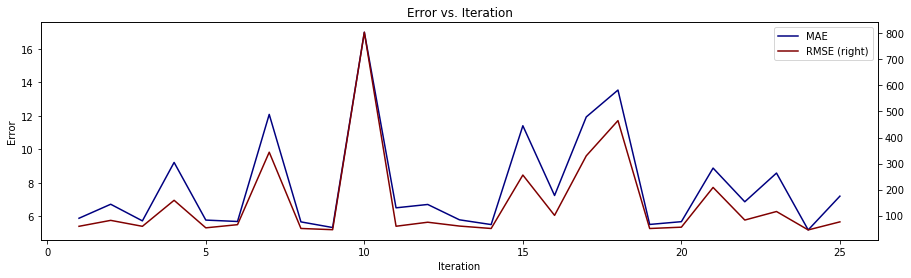

In [28]:
error_df = pd.DataFrame.from_records(errors, columns=['Iteration', 'MAE', 'RMSE'])
ax = error_df.plot(x='Iteration', y=['MAE', 'RMSE'], secondary_y=['RMSE'],
             figsize=(15,4),
             title='Error vs. Iteration',
             colormap='jet')
ax.set(ylabel='Error')
plt.show()

In [39]:
error_df.describe()

,Iteration,MAE,RMSE
count,25.000000,25.000000,25.000000
mean,13.000000,7.831691,150.002976
std,7.359801,3.079764,176.282628
min,1.000000,5.197099,45.024315
25%,7.000000,5.699770,55.570726
50%,13.000000,6.714611,74.578183
75%,19.000000,8.884142,158.813526
max,25.000000,16.985024,804.392783


Now, we'll zoom into two specific iterations (first and last) and explore their skill more deeply.

### First Model

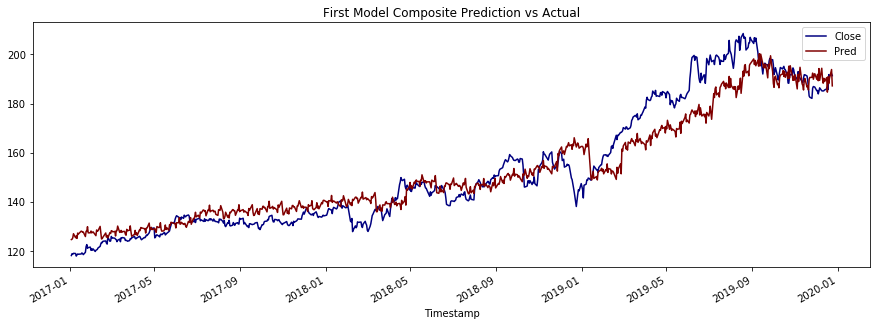

In [40]:
# Plot the first model (least training data) by sampling every 30th prediction (step) and appending to a list

first_model = []
for i in np.arange(0, len(X_test), step):
    first_model.append(pred_dict[0][i]['Pred'])

#unravel the array to plot the prediction over the actual
first_pred = np.concatenate(first_model).ravel().tolist()

#create a df with the timestamps and actual Close prices
first_results = pd.DataFrame(day_test['Close']) #base_test[step:]

#trim the length to match base_test as the last step isn't exactly 30 due to training set size
first_results = first_results[:len(first_pred)]

#add the prediction to the df
first_results['Pred'] = first_pred

#plot the df
first_results.plot(figsize=(15,5), 
                   title='First Model Composite Prediction vs Actual',
                   colormap='jet')

In [30]:
#Aggregate Error for the Composite Line above

total_MAE = metrics.mean_absolute_error(first_results['Close'], first_results['Pred'])
total_RMSE = metrics.mean_squared_error(first_results['Close'], first_results['Pred'])

print('Aggregate Error for the Composite Line')
print('Mean Absolute Error:',total_MAE)
print('Mean Squared Error:',total_RMSE)

Aggregate Error for the Composite Line
Mean Absolute Error: 6.129555023193359
Mean Squared Error: 63.071596635293815


In [31]:
#Pearson Correlation for First Model

first_corr = first_results.corr(method='pearson')['Close']['Pred']
print ('Pearson Correlation for Close & Prediction:',first_corr)

Pearson Correlation for Close & Prediction: 0.961954422326547


In [32]:
#Plot the First Models Error by Prediction Horizon ie. Error at t+1 through t+30

first_error = pred_dict[0][0]

#Sample the predictions
for i in np.arange(1,len(X_test),step):
    two = pd.DataFrame(pred_dict[0][i])
    three = first_error.append(two, ignore_index=True)
    first_error = three
    
#get the length of actual
length = len(day_test['Close'][step:])

#trim first error to right length
first_error = first_error[:length]

#Add the Actual Values
first_error['Actual'] = day_test['Close'][step:].values

#intialize a list
first_error_by_day = list()

#calcualte the errors at each day by slicing the df
for i in range(1,31):
    df = first_error[first_error.Day == i]
    err_MSE = metrics.mean_squared_error(df['Actual'],df['Pred'])
    err_MAE = metrics.mean_absolute_error(df['Actual'],df['Pred'])
    error = [i, err_MAE,err_MSE]
    first_error_by_day.append(error)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


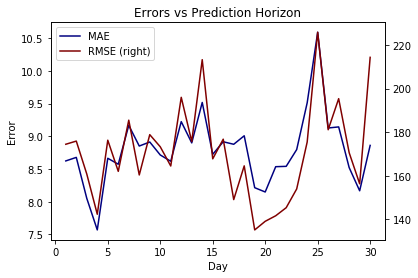

In [41]:
#Plot the Error vs Day

first_error_day = pd.DataFrame.from_records(first_error_by_day, columns=['Day', 'MAE', 'RMSE'])
first_ax = first_error_day.plot(x='Day', y=['MAE','RMSE'], 
                          secondary_y=['RMSE'], colormap='jet',
                         title = 'Errors vs Prediction Horizon')
first_ax.set(ylabel='Error')
plt.show()

### Last Model

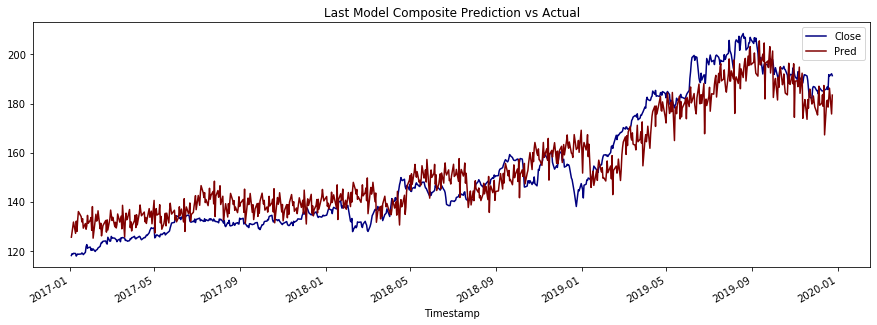

In [42]:
# Plot the last model (most training data) by sampling every 30th prediction (step) and appending to a list

last_model = []
for i in np.arange(0,len(X_test),step):
    last_model.append(pred_dict[max(pred_dict)][i]['Pred'])

#unravel the array to plot the prediction over the actual
last_pred = np.concatenate(last_model).ravel().tolist()

#create a df with the timestamps and actual Close prices
last_results = pd.DataFrame(day_test['Close']) #base_test[step:]

#trim the length to match base_test as the last step isn't exactly 30 due to training set size
last_results = last_results[:len(last_pred)]

#add the prediction to the df
last_results['Pred'] = last_pred

#plot the df
last_results.plot(figsize=(15,5), colormap='jet',
                  title='Last Model Composite Prediction vs Actual')

In [35]:
#Aggregate Error for the Composite Line above
last_total_MAE = metrics.mean_absolute_error(last_results['Close'], last_results['Pred'])
last_total_RMSE = metrics.mean_squared_error(last_results['Close'], last_results['Pred'])

print('Aggregate Error for the Composite Line')
print('Mean Absolute Error:',last_total_MAE)
print('Mean Squared Error:',last_total_RMSE)

Aggregate Error for the Composite Line
Mean Absolute Error: 7.294717995605468
Mean Squared Error: 76.6407989682175


In [36]:
last_corr = last_results.corr(method='pearson')['Close']['Pred']
print ('Pearson Correlation for Close & Prediction:',last_corr)

Pearson Correlation for Close & Prediction: 0.9551976251945344


In [37]:
#sample the last models predicitons to see the error by forecast day

last_error = pred_dict[max(pred_dict)][0]

#sample the predictions
for i in np.arange(1,len(X_test),step):
    two = pd.DataFrame(pred_dict[max(pred_dict)][i])
    three = last_error.append(two, ignore_index=True)
    last_error = three

#get the length of actual
length = len(day_test['Close'][step:])

#trim first error to right length
last_error = last_error[:length]

#Add the Actual Values
last_error['Actual'] = day_test['Close'][step:].values

#create a list
last_error_by_day = list()

#calculate the error by day
for i in range(1,31):
    df = last_error[last_error.Day == i]
    err_MSE = metrics.mean_squared_error(df['Actual'],df['Pred'])
    err_MAE = metrics.mean_absolute_error(df['Actual'],df['Pred'])
    error = [i, err_MAE,err_MSE]
    last_error_by_day.append(error)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


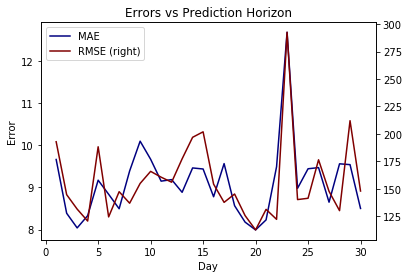

In [43]:
#Plot the Error vs Day

last_error_day = pd.DataFrame.from_records(last_error_by_day, columns=['Day', 'MAE', 'RMSE'])
last_ax = last_error_day.plot(x='Day', y=['MAE','RMSE'], 
                          secondary_y=['RMSE'], colormap='jet',
                         title = 'Errors vs Prediction Horizon')
last_ax.set(ylabel='Error')
plt.show()